<h1>Levenberg-Marquardt Neural Networks Optimization with Tensorflow</h1>
<h2>Introduction</h2>
The Levenberg-Marquardt (LM) algorithm is the most widely used optimization algorithm. It outperforms simple gradient descent and other conjugate gradient methods in a wide variety of problems, although it does require more memory than other algorithms. This tutorial shows how to train a neural network using the Levenberg Marquardt algorith.
<h2>Imports</h2>

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import math
import timeit
%matplotlib inline

C:\Python64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<h2>Rosenbrock function</h2>
We will use Rosenbrock function as a performance test problem. Let's start with its two variables and two parameters form: <i>f(x, y) = (a - x)^2 + b(y - x^2)^2</i>.

In [2]:
def rosenbrock(x, y, a, b):
    return (a - x)**2 + b*(y - x**2)**2

# consider this function on the square [-2,2]x[-1,3]
x_grid, y_grid = np.meshgrid(np.arange(-2, 2.1, 0.2), 
                             np.arange(-1, 3.1, 0.2))
# with parameters a = 1 and b = 100
z_grid = rosenbrock(x_grid, y_grid, 1, 100)

<h2>Function for plotting</h2>

In [3]:
GRAY1, GRAY3, GRAY4, GRAY7 = '#646369', '#555655', '#646369', '#929497'
BLUE1, BLUE2 = '#4A81BF', '#174A7E'

# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
# configure mathtext bold and italic font family to Arial
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

def prepare_3d_plot_for_rosenbrock(title=None, footnote=None):
    fig = plt.figure(figsize=(8, 5), dpi=110)
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(bottom=0.1)
    ax.grid(False)
    ax.set_zticks([])
    ax.w_zaxis.line.set_lw(0.)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xlabel('x', color=GRAY3)
    ax.set_ylabel('y', color=GRAY3)
    ax.w_xaxis.line.set_color(GRAY7)
    ax.w_yaxis.line.set_color(GRAY7)
    ax.w_zaxis.line.set_color(GRAY7)
    for i in ax.get_yticklabels() + ax.get_xticklabels() + ax.get_zticklabels():
        i.set_fontsize(8)
        i.set_color(GRAY1)
    ax.view_init(40, -120)
    if title:
        ax.text2D(0.12, 0.85, title, color=GRAY4, 
                  fontsize=12, transform=ax.transAxes)
    if footnote:
        ax.text2D(0.12, -0.07, footnote, fontsize=10, 
                  color=GRAY3, transform=ax.transAxes)    
    return ax

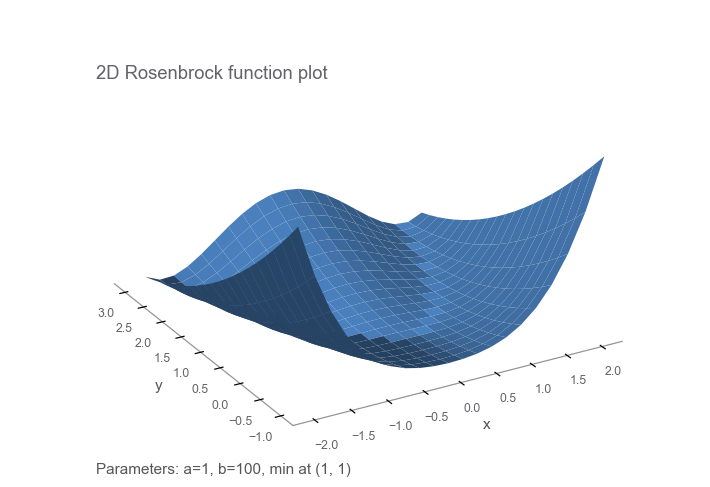

In [4]:
# let's plot it
ax = prepare_3d_plot_for_rosenbrock(
    '2D Rosenbrock function plot',
    'Parameters: а=1, b=100, min at (1, 1)')
ax.plot_surface(x_grid, y_grid, z_grid, color=BLUE1)

<h2>The Problem</h2>
The problem for which the LM algorithm provides a solution is called <i>Nonlinear Least Squares Minimization</i>. Suppose from an experiment we have as set of <i>m</i> data points, <i>(x1, y1, z1), (x2, y2, z2),..., (xm, ym, zm)</i>. Our goal is to be able to predict <i>z</i> for any pair <i>(x, y)</i>. We have a model function <i>z = rosenbrock(x, y, a, b)</i>, that in addition to the variables <i>(x, y)</i> also depends on parameters <i>a, b</i>. It is desired to find these parameters such that the surface fits best the given data in the least squares sense. LM algorithm uses the Jacobian for calculations, which assumes that performance is a mean or sum of squared errors. Therefore, networks trained with this function must use tf.reduce_mean(tf.square(y - y_hat)) performance function.

In [5]:
# generate some data points from an "experiment"
data_points = np.array([[x, y, rosenbrock(x, y, 0.5, 0.5)]
                       for x in np.arange(-2, 2.1, 2) 
                       for y in np.arange(-2, 2.1, 2)])
m = data_points.shape[0]

# now, please, forget about actual paramenters (0.5, 0.5)
# suppose they are unknown and our goal is to estimate them 
# using only data_points and knowledge about our model

# we start with guessing
a_guess, b_guess = 5., 5.
# predictions usually have -hat suffix
z_hat = rosenbrock(data_points[:,0], data_points[:,1], a_guess, b_guess)
# residual is the difference between the measured value and the predicted value
r = data_points[:,2] - z_hat
# mse
loss = np.mean(r**2)
# our guess is bad :(. Let's try another guess?
print(loss)

10926.5625


<h2>The Problem Graphical Representation</h2>
We can plot the data points from the experiment as dots, our model as a suface and the residuals as lines connecting data dots to the model surface. See how far the data points are from the model. We need to find better <i>a, b</i> to make it closer.

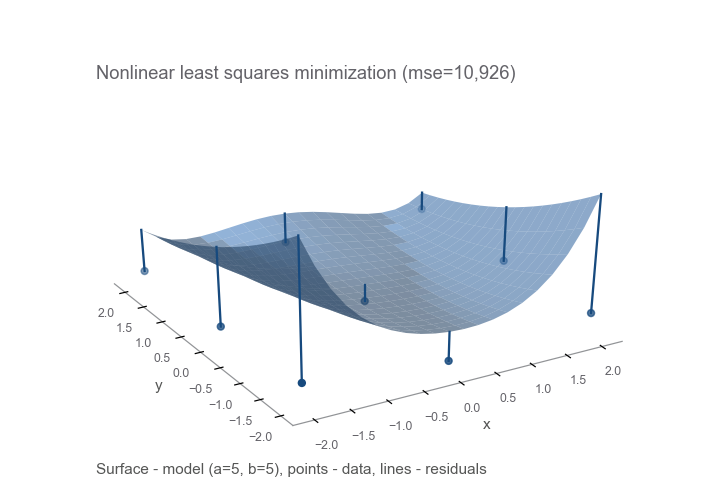

In [6]:
ax = prepare_3d_plot_for_rosenbrock(
    'Nonlinear least squares minimization (mse=10,926)',
    'Surface - model (a=5, b=5), points - data, lines - residuals')
# plot data points from an experiment
ax.scatter(data_points[:,0], 
           data_points[:,1], 
           data_points[:,2], 
           color=BLUE2)
# plot our model surface 
x_grid, y_grid = np.meshgrid(np.arange(-2, 2.1, 0.2), 
                             np.arange(-2, 2.1, 0.2))
z_hat_grid = rosenbrock(x_grid, y_grid, a_guess, b_guess)
ax.plot_surface(x_grid, y_grid, z_hat_grid, alpha=0.6, color=BLUE1)
# plot residuals as lines
for i in range(m):
    ax.plot([data_points[i, 0], data_points[i, 0]], 
            [data_points[i, 1], data_points[i, 1]], 
            [data_points[i, 2], z_hat[i]], c=BLUE2)

<h2>Tensorflow Problem Definition</h2>
From now let's start using more common convention for naming. Instead of <i>z = f(x, y, a, b)</i> we'll use <i>y = f(x, p)</i>, where <i>x</i> and <i>p</i> are vectors. In the case of 2D rosenbrock they are vectors of 2. On the next step we'll construct so-called computational graph. Please, note that no actual computation is performed.

In [7]:
# placeholder variables (we have m data points)
x = tf.placeholder(tf.float64, shape=[m, 2])
y = tf.placeholder(tf.float64, shape=[m])
# variable to be optimized with initial guess
p = tf.Variable([a_guess, b_guess], dtype=tf.float64)
# model 
y_hat = rosenbrock(x[:, 0], x[:, 1], p[0], p[1])
# residuals
r = y - y_hat
#cost-function to be optimized
loss = tf.reduce_mean(r**2)

In [8]:
# construct so-called feed dictionary to map placeholders to actual values
feed_dict = {x: data_points[:,0:2], y: data_points[:,2]}

<h2>TensorFlow Session Start</h2>

In [9]:
# create TensorFlow session
session = tf.Session()
# initialize variables
session.run(tf.global_variables_initializer())
# calculate loss using tensorflow  if everything is correct, 
# the loss equals to the previously calcualted by means of numpy
current_loss = session.run(loss, feed_dict)
print(current_loss)

10926.5625


<h2>Optimization</h2>
Now that we have a model and a loss measure that must be minimized, we can then create an optimizer. Levenberg-Marquardt is a mixture of Newton-Gauss and a basic form of Gradient Descent. Let's start with Gradient Descent. There is an easy way to create an optimizer, but let's do some more work and implement it ourselves.
<h3>Training Loop</h3>
Let's implement a simple training loop. That optimizes loss step by step and prints progress information.

In [10]:
def train(target_loss, max_steps, loss_tensor, train_step_op, inputs):
    step = 0
    # calc initial loss
    current_loss = session.run(loss_tensor, inputs)
    while current_loss > target_loss and step < max_steps:
        step += 1
        if math.log(step, 2).is_integer():
            print(f'step: {step}, current loss: {current_loss}')
        session.run(train_step_op, inputs)
        current_loss = session.run(loss_tensor, inputs)
    print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')

<h3>Steepest Gradient Descent Optimization</h3>

In [11]:
# create an optimizer object
opt = tf.train.GradientDescentOptimizer(learning_rate=1)
# calculate the vector of partial derivatives of the loss function with respect to a and b
grad = tf.gradients(loss, p)[0]
# set our guess for learning rate
learning_rate = 0.0005
# define the gradient descent step
sgd = opt.apply_gradients([(learning_rate*grad, p)])

In [12]:
# let's run gradient descent optimization
session.run(tf.global_variables_initializer())
train(1e-10, 40000, loss, sgd, feed_dict)

step: 1, current loss: 10926.5625
step: 2, current loss: 3912.53059022486
step: 4, current loss: 649.023221530936
step: 8, current loss: 104.26260832592729
step: 16, current loss: 63.84173181457582
step: 32, current loss: 34.167328999515775
step: 64, current loss: 12.280539954754168
step: 128, current loss: 2.2637454885043584
step: 256, current loss: 0.11214110836420908
step: 512, current loss: 0.0003491733504096855
step: 1024, current loss: 3.6137088344542087e-09
ENDED ON STEP: 1184, FINAL LOSS: 9.786740845547185e-11


<h3>Newton's Method</h3>

In [15]:
hess = tf.hessians(loss, p)[0]
dx = tf.squeeze(tf.matmul(tf.linalg.inv(hess), tf.reshape(grad, shape=(-1,1))))
newton = opt.apply_gradients([(dx, p)])

In [16]:
session.run(tf.global_variables_initializer())
train(1e-10, 40000, loss, newton, feed_dict)

step: 1, current loss: 10926.5625
step: 2, current loss: 308.9451027333862
step: 4, current loss: 9.966635267042346
ENDED ON STEP: 7, FINAL LOSS: 3.941847219751424e-17


<h3>Newton-Gauss Optimization</h3>

In [17]:
# calculate jacobian
j = tf.stack([tf.gradients(y_i, p)[0]
              for y_i in tf.unstack(y_hat)])
jT = tf.transpose(j)
rT = tf.reshape(r, [m, 1])
hess = tf.matmul(jT, j)
dx = tf.squeeze(tf.matmul(tf.matmul(tf.linalg.inv(hess), jT), rT))
ng = opt.apply_gradients([(-dx, p)])

In [18]:
session.run(tf.global_variables_initializer())
train(1e-10, 40000, loss, ng, feed_dict)

step: 1, current loss: 10926.5625
step: 2, current loss: 71.9484571828391
step: 4, current loss: 0.0040755990866368115
ENDED ON STEP: 5, FINAL LOSS: 3.0880667712978386e-24


<h3>Gradient Descent Variation - Adam Optimization</h3>

In [19]:
adm = tf.train.AdamOptimizer(15).minimize(loss)

In [20]:
session.run(tf.global_variables_initializer())
train(1e-10, 40000, loss, adm, feed_dict)

step: 1, current loss: 10926.5625
step: 2, current loss: 22004.062497807172
step: 4, current loss: 46503.284103374164
step: 8, current loss: 2166.397335724172
step: 16, current loss: 31830.082083760088
step: 32, current loss: 1999.205020564346
step: 64, current loss: 61.97644503317138
step: 128, current loss: 0.08450989936172908
step: 256, current loss: 2.4735677658838122e-08
ENDED ON STEP: 310, FINAL LOSS: 7.740586036543351e-11


<h2>MLP Neural Network</h2>

In [21]:
def fnc(x):
    return 1/x

def generate_data_points(m, rng, f):
    return np.array([[x, f(x)] for x in np.linspace(*rng, m)])

In [22]:
m = 100
data_points = generate_data_points(m, (0.2, 0.8), fnc)

In [23]:
n_hidden = 10
initializer = tf.contrib.layers.xavier_initializer()

# placeholder variables (we have m data points)
x = tf.placeholder(tf.float64, shape=[m, 1])
y = tf.placeholder(tf.float64, shape=[m, 1])

# variables to be optimized with initial guess
W1 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
b1 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
h1 = tf.nn.tanh(tf.matmul(x, W1) + b1)

W2 = tf.Variable(initializer([n_hidden, 1], dtype=tf.float64))
b2 = tf.Variable(initializer([1], dtype=tf.float64))

y_hat = tf.matmul(h1, W2) + b2

#cost-function to be optimized
loss = tf.reduce_mean(tf.square(y - y_hat))

In [24]:
# construct so-called feed dictionary to map placeholders to actual values
feed_dict = {x: data_points[:,0:1], y: data_points[:,1:2]}

In [25]:
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)
session.run(tf.global_variables_initializer())
train(1e-10, 40000, loss, adm, feed_dict)

step: 1, current loss: 8.778127444713364
step: 2, current loss: 8.280768554773372
step: 4, current loss: 7.33240971960784
step: 8, current loss: 5.638580759673643
step: 16, current loss: 3.1301750011172866
step: 32, current loss: 1.3252948847330464
step: 64, current loss: 1.1580756539487485
step: 128, current loss: 0.8043795980573176
step: 256, current loss: 0.1633473932908524
step: 512, current loss: 0.09234883030208499
step: 1024, current loss: 0.01908023628766836
step: 2048, current loss: 0.004549245500689098
step: 4096, current loss: 0.0006402277660486442
step: 8192, current loss: 0.00017736668153667416
step: 16384, current loss: 2.4983919116465183e-06
step: 32768, current loss: 1.678215766279772e-06
ENDED ON STEP: 40000, FINAL LOSS: 1.5603270925551964e-06


<h2>Levenberg Marquardt</h2>
Like the quasi-Newton methods, the Levenberg-Marquardt algorithm was designed to approach second-order training speed without having to compute the Hessian matrix. When the performance function has the form of a sum of squares (as is typical in training feedforward networks), then the Hessian matrix can be approximated as <i>H = JTJ</i> and and the gradient can be computed as <i>g = JTe</i>, where <i>J</i> is the Jacobian matrix that contains first derivatives of the network errors with respect to the weights and biases, and e is a vector of network errors. The Jacobian matrix can be computed through a standard backpropagation technique that is much less complex than computing the Hessian matrix.<br><br>
The Levenberg-Marquardt algorithm uses this approximation to the Hessian matrix in the following Newton-like update:<br>
<i>xk+1=xk−[JTJ+μI]^−1JTe</i><br><br>
When the scalar µ is zero, this is just Newton’s method, using the approximate Hessian matrix. When µ is large, this becomes gradient descent with a small step size. Newton’s method is faster and more accurate near an error minimum, so the aim is to shift toward Newton’s method as quickly as possible. Thus, µ is decreased after each successful step (reduction in performance function) and is increased only when a tentative step would increase the performance function. In this way, the performance function is always reduced at each iteration of the algorithm.<br><br>
This algorithm appears to be the fastest method for training moderate-sized feedforward neural networks (up to several hundred weights).

In [26]:
def jacobian(y, x):
    loop_vars = [
        tf.constant(0, tf.int32),
        tf.TensorArray(tf.float64, size=m),
    ]

    _, jacobian = tf.while_loop(
        lambda i, _: i < m,
        lambda i, res: (i+1, res.write(i, tf.reshape(tf.gradients(y[i], x), (-1,)))),
        loop_vars)

    return jacobian.stack()

In [27]:
mu = tf.placeholder(tf.float64, shape=[1])

parms = [W1, b1, W2, b2]
store = [tf.Variable(tf.zeros(p.shape, dtype=tf.float64)) for p in parms]

save_parms = [tf.assign(s, p) for s, p in zip(store, parms)]
restore_parms = [tf.assign(p, s) for s, p in zip(store, parms)]

parms_sizes = [tf.size(p) for p in parms]
n = tf.add_n(parms_sizes)
I = tf.eye(n, dtype=tf.float64)

y_hat_flat = tf.squeeze(y_hat)
j = tf.concat([jacobian(y_hat_flat, p) for p in parms], 1)
jT = tf.transpose(j)
r = y - y_hat
dx = tf.matmul(tf.matmul(tf.linalg.inv(tf.matmul(jT, j) + tf.multiply(mu, I)), jT), r)

grads = tf.split(dx, parms_sizes, 0)
for i in range(len(grads)):
    grads[i] = -tf.reshape(grads[i], parms[i].shape)
    
lm = opt.apply_gradients(zip(grads, parms))

In [28]:
feed_dict[mu] = np.array([3.])
step = 0
session.run(tf.global_variables_initializer())
current_loss = session.run(loss, feed_dict)
while current_loss > 1e-10 and step < 4000:
    step += 1
    if math.log(step, 2).is_integer():
        print(f'step: {step}, mu: {feed_dict[mu][0]} current loss: {current_loss}')
    session.run(save_parms)
    while True:
        session.run(lm, feed_dict)
        new_loss = session.run(loss, feed_dict)
        if new_loss > current_loss:
            feed_dict[mu] *= 10
            session.run(restore_parms)
        else:
            feed_dict[mu] /= 10
            current_loss = new_loss
            break
        
print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')

step: 1, mu: 3.0 current loss: 7.304124480229172
step: 2, mu: 0.3 current loss: 0.6057962535190505
step: 4, mu: 0.3 current loss: 0.05865422312696236
step: 8, mu: 0.003 current loss: 0.0003597518778273244
step: 16, mu: 0.00030000000000000003 current loss: 1.4324340856693423e-05
step: 32, mu: 0.00030000000000000003 current loss: 1.7220458441258679e-06
step: 64, mu: 3.0000000000000004e-05 current loss: 1.6895575439480995e-07
step: 128, mu: 3.0000000000000005e-06 current loss: 4.304927981946327e-09
step: 256, mu: 3.0000000000000005e-06 current loss: 1.6071260268223153e-09
step: 512, mu: 3.0000000000000005e-06 current loss: 1.2885404455741277e-09
step: 1024, mu: 3.0000000000000005e-06 current loss: 1.004189319447487e-09
step: 2048, mu: 3.0000000000000004e-07 current loss: 1.3280871504918457e-10
ENDED ON STEP: 2092, FINAL LOSS: 9.948077788750661e-11


<h2>Multidimensional Rosenbrock </h2>

In [29]:
def generate_rosenbrock_data_points(N, m, x_range, x_norm=None, y_norm=None):
    x = np.random.uniform(*x_range, (m, N))
    y = np.zeros(shape=(m, 1), dtype=np.float64)
    # include local and global minima for 4 <= N <= 7 for checks
    x[0, :] = ([-1] + [1]*(N-1)) 
    x[1, :] = [1]*N
    for s in range(m):
        for i in range(N - 1):
            y[s] += 100*((x[s, i+1]-x[s, i]**2)**2) + (1-x[s,i])**2
    if not x_norm:
        x_norm = max(x_range)
    if not y_norm:
        y_norm = max(y)[0]
    x = x/x_norm
    y = y/y_norm - 0.5
    return x, y, x_norm, y_norm

In [30]:
#m, N = 15000, 10
m, N = 5000, 4
dp_x, dp_y, x_norm, y_norm = generate_rosenbrock_data_points(N, m, (-2, 2))

In [31]:
#nn = [32, 16]
nn = [8, 4]
st = [N]+nn+[1]
sizes = []
shapes = []
for i in range(len(nn)+1):
    shapes.append((st[i], st[i+1]))
    shapes.append((1, st[i+1]))
sizes = [h*w for h, w in shapes]
neurons_cnt = sum(sizes)
shapes, sizes, neurons_cnt

([(4, 8), (1, 8), (8, 4), (1, 4), (4, 1), (1, 1)], [32, 8, 32, 4, 4, 1], 81)

In [32]:
activation = tf.nn.tanh

In [33]:
def jacobian(y, x):
    loop_vars = [
        tf.constant(0, tf.int32),
        tf.TensorArray(tf.float64, size=m),
    ]

    _, jacobian = tf.while_loop(
        lambda i, _: i < m,
        lambda i, res: (i+1, res.write(i, tf.gradients(y[i], x)[0])),
        loop_vars)

    return jacobian.stack()

In [34]:
# placeholder variables (we have m data points)
x = tf.placeholder(tf.float64, shape=[m, N])
y = tf.placeholder(tf.float64, shape=[m, 1])

p = tf.Variable(initializer([neurons_cnt], dtype=tf.float64))
parms = tf.split(p, sizes, 0)
for i in range(len(parms)):
    parms[i] = tf.reshape(parms[i], shapes[i])
Ws = parms[0:][::2]
bs = parms[1:][::2]

y_hat = x
for i in range(len(nn)):
    y_hat = activation(tf.matmul(y_hat, Ws[i]) + bs[i])
y_hat = tf.matmul(y_hat, Ws[-1])+bs[-1]
y_hat_flat = tf.squeeze(y_hat)

r = y - y_hat
loss = tf.reduce_mean(tf.square(r))


mu = tf.placeholder(tf.float64, shape=[1])

p_store = tf.Variable(tf.zeros([neurons_cnt], dtype=tf.float64))

save_parms = tf.assign(p_store, p)
restore_parms = tf.assign(p, p_store)
                      
I = tf.eye(neurons_cnt, dtype=tf.float64)

j = jacobian(y_hat_flat, p)
jT = tf.transpose(j)
jTj = tf.matmul(jT, j)
jTr = tf.matmul(jT, r)

# remove it
jTj = tf.hessians(loss, p)[0]
jTr = -tf.gradients(loss, p)[0]
jTr = tf.reshape(jTr, shape=(neurons_cnt, 1))

jTj_store = tf.Variable(tf.zeros((neurons_cnt, neurons_cnt), dtype=tf.float64))
jTr_store = tf.Variable(tf.zeros((neurons_cnt, 1), dtype=tf.float64))
save_jTj_jTr = [tf.assign(jTj_store, jTj), tf.assign(jTr_store, jTr)]


dx = tf.matmul(tf.linalg.inv(jTj_store + tf.multiply(mu, I)), jTr_store)
dx = tf.squeeze(dx)
_dx = tf.matmul(tf.linalg.inv(jTj + tf.multiply(mu, I)), jTr)
_dx = -tf.squeeze(_dx)

lm = opt.apply_gradients([(-dx, p)])

In [35]:
feed_dict = {x: dp_x, y: dp_y}

In [36]:
feed_dict[mu] = np.array([3.])
step = 0
session.run(tf.global_variables_initializer())
current_loss = session.run(loss, feed_dict)
while current_loss > 1e-10 and step < 4000:
    step += 1
    if math.log(step, 2).is_integer():
        print(f'step: {step}, mu: {feed_dict[mu][0]}, current loss: {current_loss}')        
    session.run(save_parms)
    session.run(save_jTj_jTr, feed_dict)
    success = False
    for i in range(10):
        session.run(lm, feed_dict)
        new_loss = session.run(loss, feed_dict)
        if new_loss < current_loss:
            feed_dict[mu] /= 10
            current_loss = new_loss
            success = True
            break
        feed_dict[mu] *= 10
        session.run(restore_parms)
    if not success:
        print('Failed to improve')
        break
        
print(f'ENDED ON STEP: {step}, FINAL LOSS: {current_loss}')

step: 1, mu: 3.0, current loss: 0.11726154777834595
step: 2, mu: 0.3, current loss: 0.05368460936838017
step: 4, mu: 0.003, current loss: 0.021581531644741143
step: 8, mu: 0.03, current loss: 0.021133401191026763
step: 16, mu: 0.03, current loss: 0.01872397456847985
step: 32, mu: 0.003, current loss: 0.007582473790032636
step: 64, mu: 0.003, current loss: 0.0009785208028949394
step: 128, mu: 0.00030000000000000003, current loss: 0.0003103878792467947
step: 256, mu: 0.00030000000000000003, current loss: 2.00412943114542e-05


KeyboardInterrupt: 

In [74]:
adm = tf.train.AdamOptimizer(1e-3).minimize(loss)
session.run(tf.global_variables_initializer())
train(1e-10, 100000, loss, adm, feed_dict)

step: 1, current loss: 0.28128190311415785
step: 2, current loss: 0.27879520658035023
step: 4, current loss: 0.2738910737916024
step: 8, current loss: 0.2643648958986427
step: 16, current loss: 0.24644454970711435
step: 32, current loss: 0.2145261505117701
step: 64, current loss: 0.15820958691513234
step: 128, current loss: 0.05671043123114755
step: 256, current loss: 0.015945627056774988
step: 512, current loss: 0.013258142763368529
step: 1024, current loss: 0.006663022896589102
step: 2048, current loss: 0.0028409371156847747
step: 4096, current loss: 0.001260975811098222
step: 8192, current loss: 0.0005700953942950745
step: 16384, current loss: 0.0002840975202448895
step: 32768, current loss: 0.0002589814099151817
step: 65536, current loss: 0.0002520921344909969
ENDED ON STEP: 100000, FINAL LOSS: 0.0002439996085123469


0.0002439996085123469


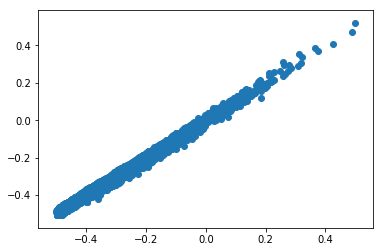

In [75]:
real_y, pred_y, l = session.run([y, y_hat_flat, loss], feed_dict)
real_y = np.squeeze(real_y)
print(l)
plt.scatter(real_y, pred_y)

0.000254496641526776


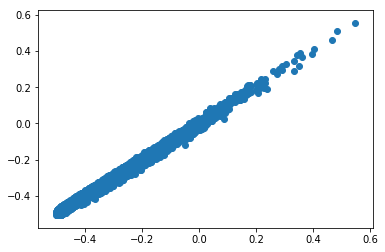

In [76]:
dp_x, dp_y, x_norm, y_norm = generate_rosenbrock_data_points(N, m, (-2, 2), x_norm, y_norm)
feed_dict = {x: dp_x, y: dp_y}
real_y, pred_y, l = session.run([y, y_hat_flat, loss], feed_dict)
real_y = np.squeeze(real_y)
print(l)
plt.scatter(real_y, pred_y)